<div style="text-align: center;">
    <h1><b>Practical Work 5 : Finite difference scheme for transport</b></h1>
</div>

*Authored in 2025 for educational purpose by S. Cardonna, Q. Richard, V. Lleras & P. Azerad. If you identify any issues or have suggestions for improvement, feel free to contact me.*  
  
**Introduction**  
This lab session focuses on solving the **linear transport equation**  
$$
\partial_t u + c \partial_x g(u) = 0, \qquad g(u):=u,
$$
using explicit finite difference methods. The goal is to implement and analyze different numerical schemes, including:  
- **Upwind scheme**  
- **Centered difference scheme**  
- **Lax-Friedrichs scheme**  
- **Lax-Wendroff scheme**  

The function `transport(c, T, xmin, xmax, dx, dt)` computes the numerical solution $u(x,t)$ on a discretized domain, given an initial condition $u(x,0) = f(x)$. The solutions are compared to the **exact solution** $u(x,T) = f(x - cT)$ to evaluate accuracy and stability.  

The impact of varying the time step $\Delta t$ and changing the transport speed $c$ is also investigated to understand the behavior of each numerical scheme.


### Implementation of the four schemes ###

Running simulation for c=0.5, dt=0.01...


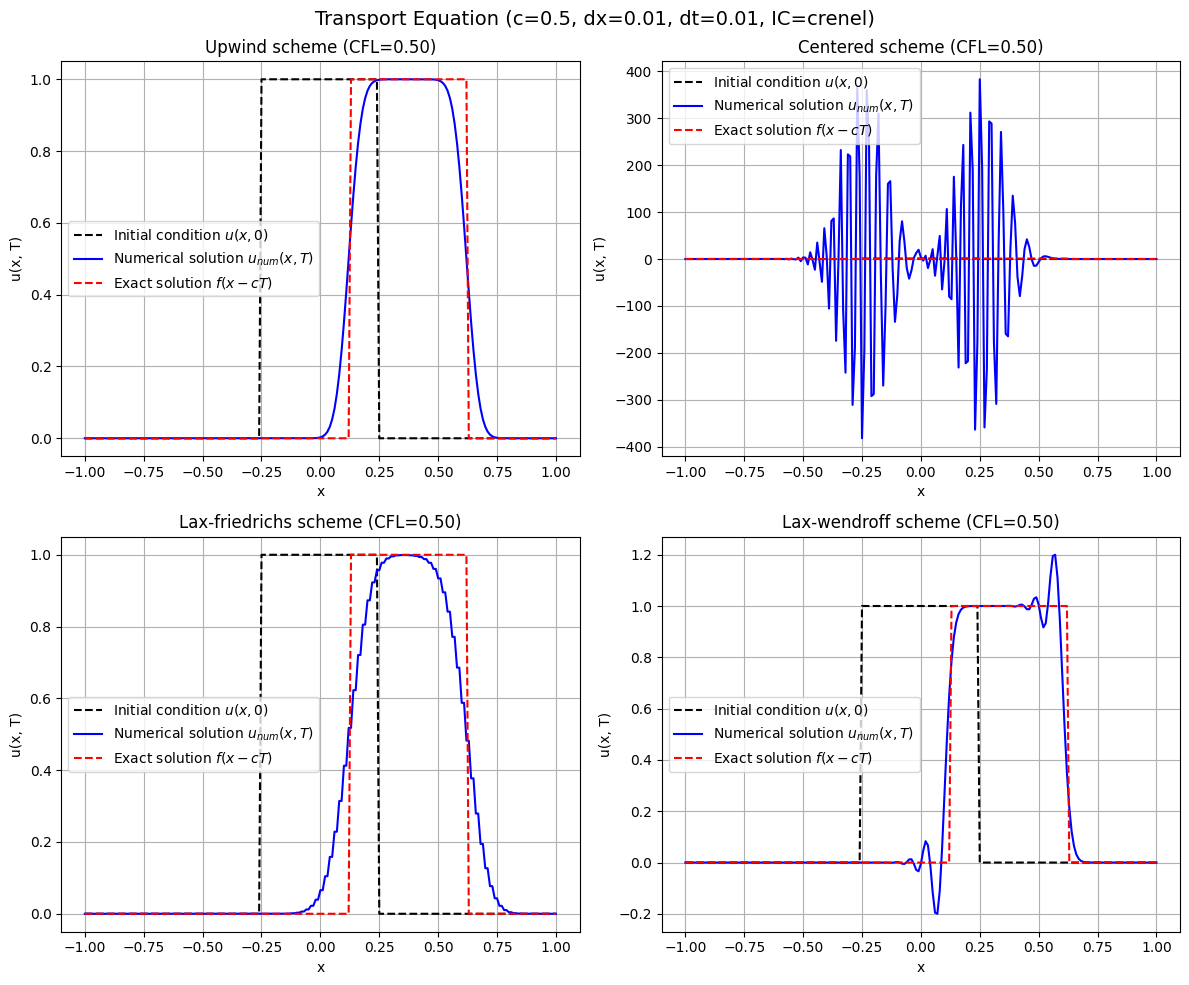

Running simulation for c=0.5, dt=0.02...


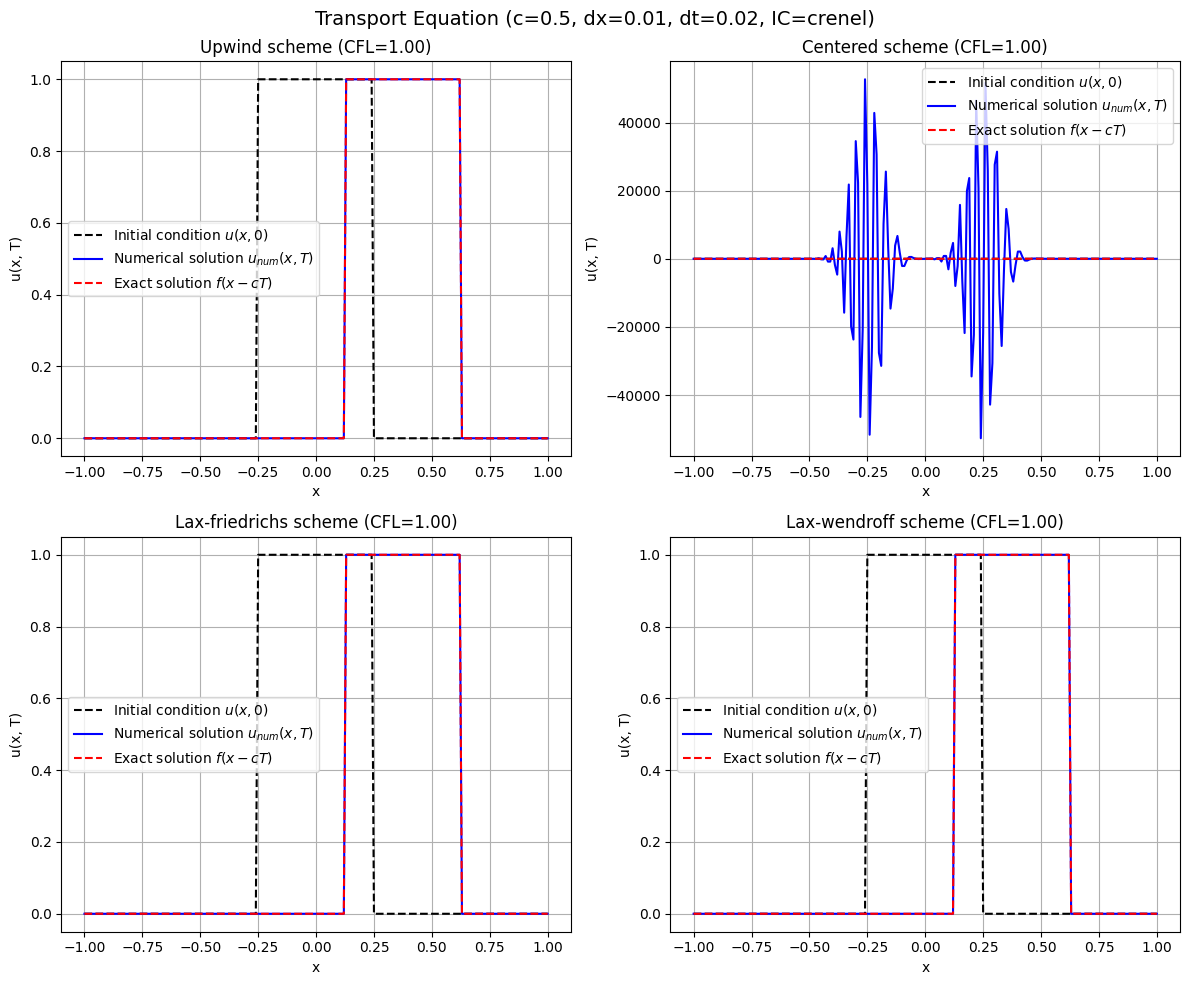

Running simulation for c=0.5, dt=0.021...


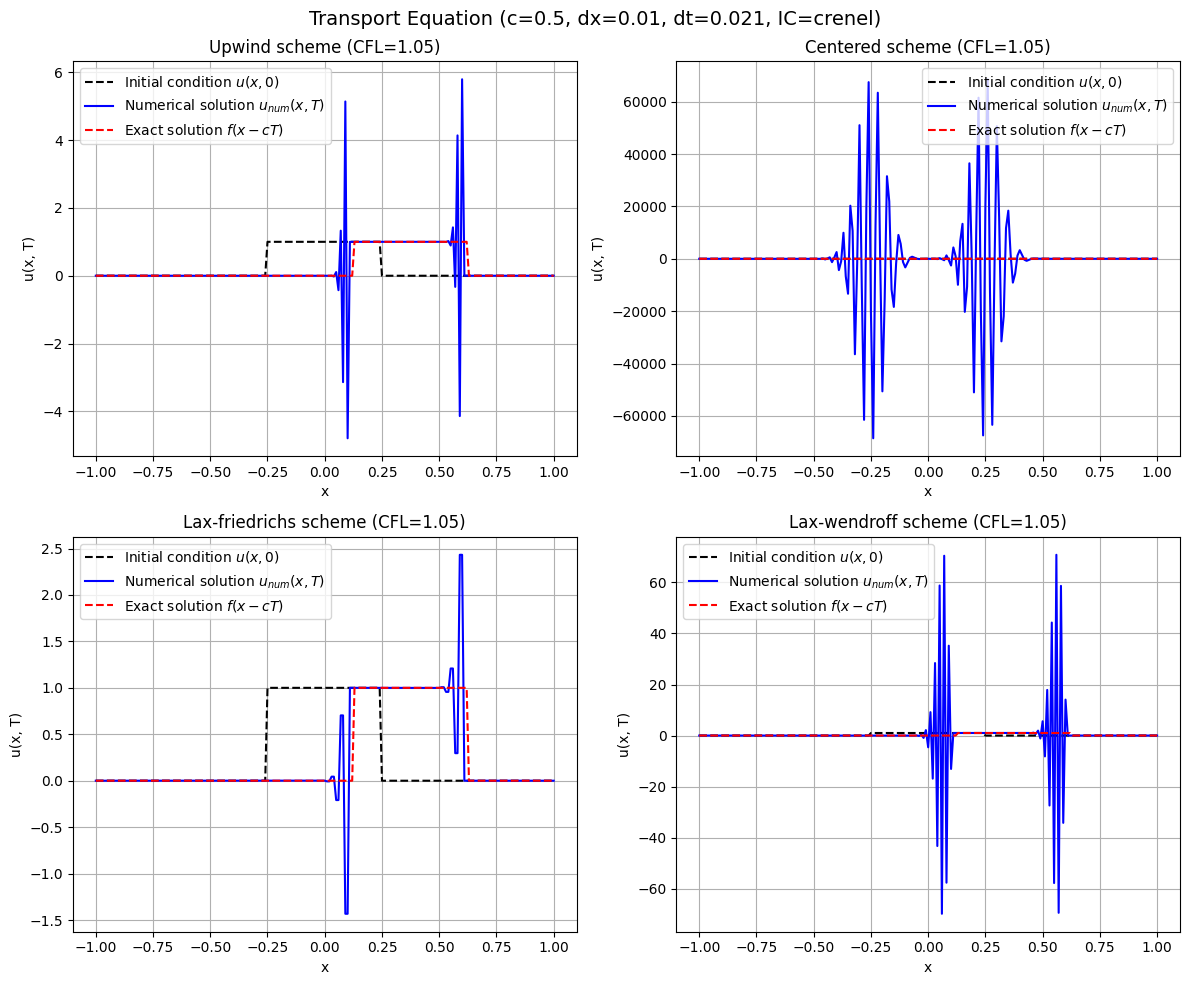

Running simulation for c=-0.5, dt=0.01...


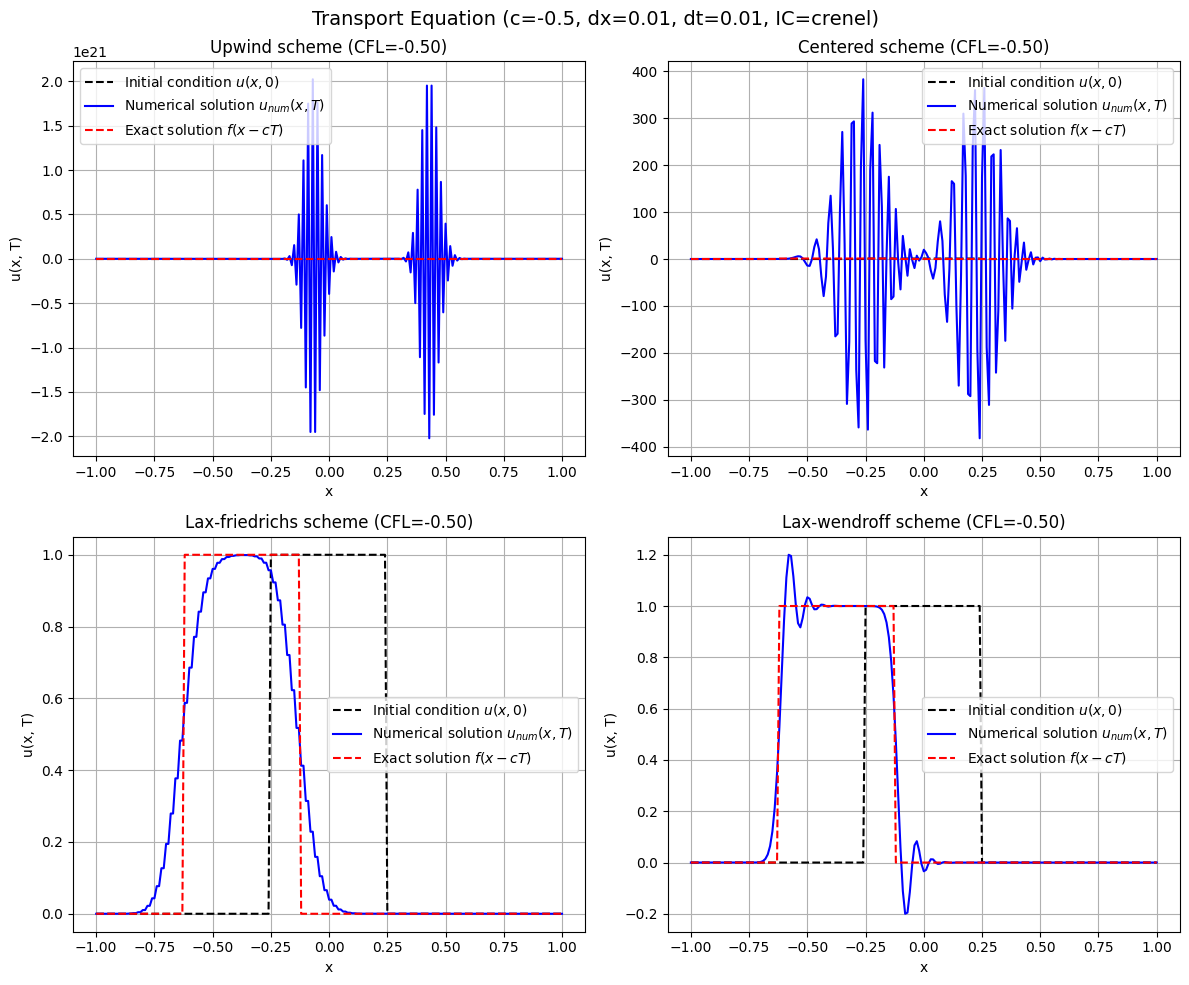

Running simulation for c=-0.5, dt=0.02...


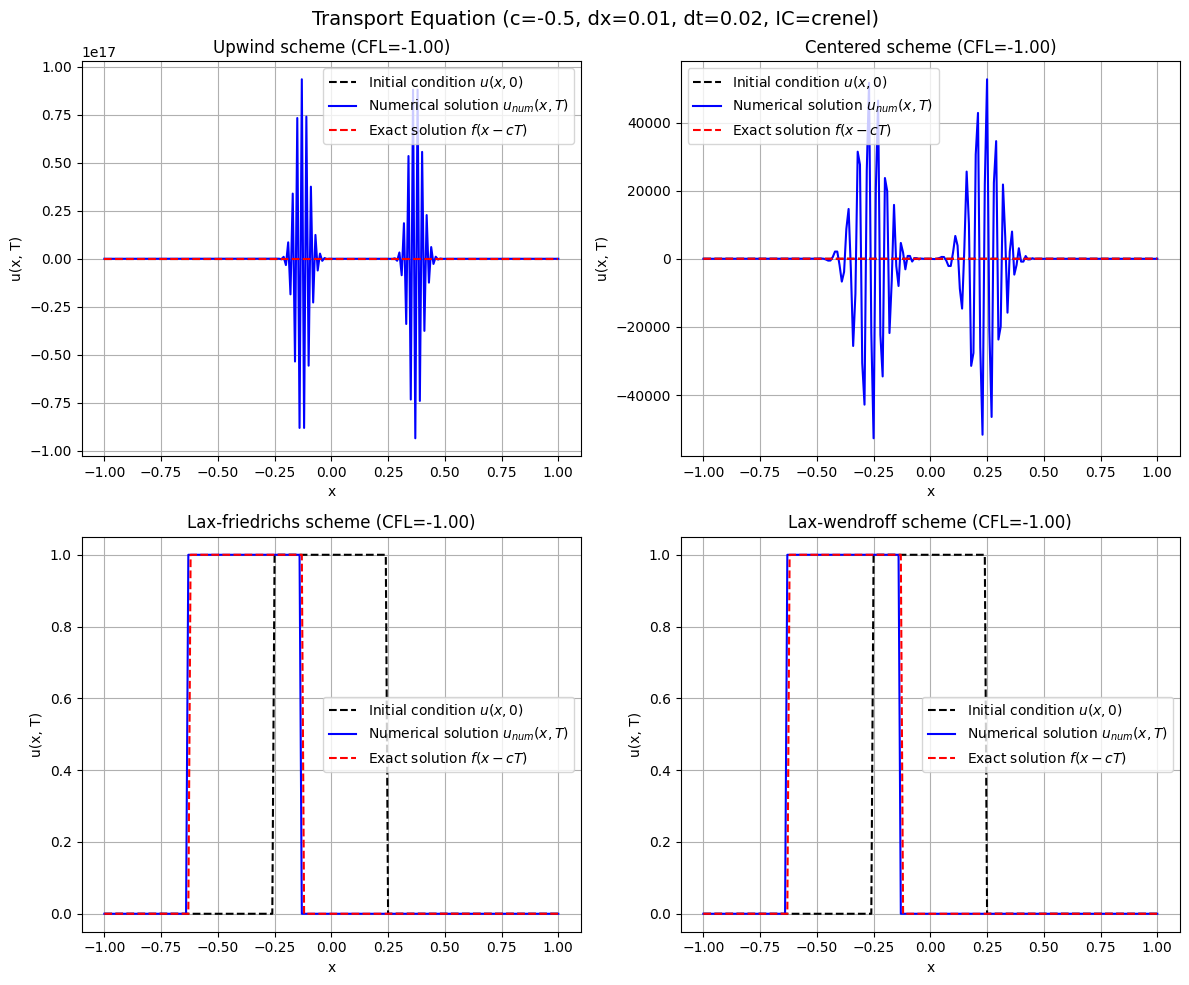

Running simulation for c=-0.5, dt=0.021...


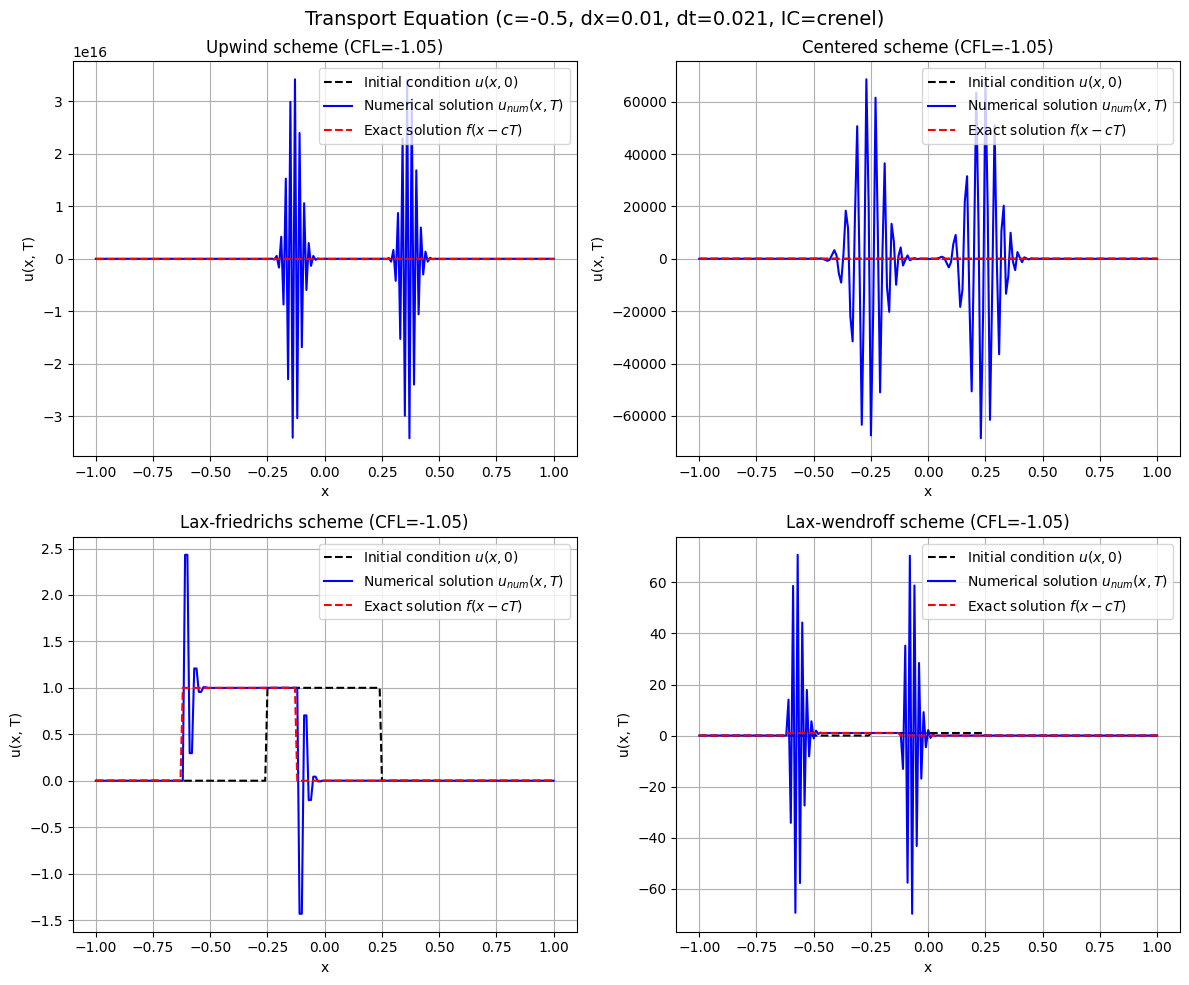

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, ic_type):
    """
    Defines the initial condition for the transport equation.
    
    Parameters:
    x (numpy array): Spatial grid.
    ic_type (str): Type of initial condition ('step', 'gaussian', 'indicator').
    
    Returns:
    numpy array: Initial condition values.
    """
    if ic_type == 'step':
        y = np.zeros_like(x)
        y[x < 0] = 1  # Step function
    elif ic_type == 'gaussian':
        y = np.exp(-25 * (x - 0.25) ** 2)  # Gaussian bell curve
    elif ic_type == 'indicator':
        y = 4 * x**2 * (3 - 4 * x) * (x >= 0) * (x < 0.5) + (x >= 0.5)  # Smooth indicator function
    elif ic_type == 'crenel':
        y = (x >= -0.25) * (x <= 0.25)    # Crenel function
    else:
        raise ValueError("Unknown initial condition type. Choose from 'step', 'gaussian', 'indicator', 'crenel'.")
    
    return y

def transport(c, T, xmin, xmax, dx, dt, scheme, ic_type):
    """
    Solves the transport equation u_t + c u_x = 0 using explicit finite difference schemes.
    
    Parameters:
    c (float): Transport velocity.
    T (float): Final time.
    xmin, xmax (float): Spatial domain limits.
    dx (float): Spatial step size.
    dt (float): Time step size.
    scheme (str): Finite difference scheme ('upwind', 'centered', 'lax-friedrichs', 'lax-wendroff').
    ic_type (str): Initial condition type ('step', 'gaussian', 'indicator', 'crenel').
    
    Returns:
    t_vals, x_vals, u_final, r (numpy arrays): Time steps, spatial grid, final solution, CFL number.
    """
    x_vals = np.arange(xmin, xmax + dx, dx)
    t_vals = np.arange(0, T + dt, dt)
    Nx, Nt = len(x_vals), len(t_vals)
    r = c * dt / dx  # CFL number
    
    u = np.zeros((Nx, Nt))
    u[:, 0] = f(x_vals, ic_type)
    
    for n in range(Nt - 1):
        u_next = np.copy(u[:, n])
        
        if scheme == "upwind":
            for j in range(1, Nx - 1):
                u_next[j] = r * u[j - 1, n] + (1 - r) * u[j, n]
        elif scheme == "centered":
            for j in range(1, Nx - 1):
                u_next[j] = (r / 2) * u[j - 1, n] + u[j, n] - (r / 2) * u[j + 1, n]
        elif scheme == "lax-friedrichs":
            for j in range(1, Nx - 1):
                u_next[j] = (0.5 + 0.5 * r) * u[j - 1, n] + (0.5 - 0.5 * r) * u[j + 1, n]
        elif scheme == "lax-wendroff":
            for j in range(1, Nx - 1):
                u_next[j] = 0.5 * (r**2 + r) * u[j - 1, n] + (1 - r**2) * u[j, n] + 0.5 * (r**2 - r) * u[j + 1, n]
        else:
            raise ValueError("Unknown scheme. Choose from 'upwind', 'centered', 'lax-friedrichs', 'lax-wendroff'.")
        
        u_next[0] = u[0, n]
        u_next[-1] = u[-1, n]
        u[:, n + 1] = u_next
    
    return t_vals, x_vals, u[:, -1], r

def plot_schemes(c, T, xmin, xmax, dx, dt, ic_type):
    """
    Runs all four schemes and plots them in a 2x2 subplot.
    Displays CFL number and initial condition in each plot.
    """
    schemes = ["upwind", "centered", "lax-friedrichs", "lax-wendroff"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Transport Equation (c={c}, dx={dx}, dt={dt}, IC={ic_type})", fontsize=14)

    for i, scheme in enumerate(schemes):
        t_vals, x_vals, u_final, cfl = transport(c, T, xmin, xmax, dx, dt, scheme, ic_type)
        x_exact = x_vals - c * T
        u_exact = f(x_exact, ic_type)

        ax = axes[i // 2, i % 2]
        ax.plot(x_vals, f(x_vals, ic_type), 'k--', label=r"Initial condition $u(x, 0)$")
        ax.plot(x_vals, u_final, 'b-', label=r"Numerical solution $u_{num}(x, T)$")
        ax.plot(x_vals, u_exact, 'r--', label=r"Exact solution $f(x - cT)$")
        ax.set_title(f"{scheme.capitalize()} scheme (CFL={cfl:.2f})")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x, T)")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()


# ==============================
# Run Simulations
# ==============================

# Parameters
c_values = [0.5, -0.5]  # Test both positive and negative velocity
dx = 0.01
dt_values = [0.01, 0.02, 0.021]  # Test different dt values
T = 0.75  # Final time
xmin, xmax = -1, 1  # Spatial domain

for c in c_values:
    for dt in dt_values:
        print(f"Running simulation for c={c}, dt={dt}...")
        plot_schemes(c, T, xmin, xmax, dx, dt, ic_type='crenel')

### Some remarks on numerical results ###

#### Stability and CFL condition ####

Sometimes, we an observe that all numerical schemes produce incorrect results. This happens because the **CFL number** exceeds 1:
$$
\text{CFL} = \frac{c \Delta t}{\Delta x} > 1
$$
The **Courant-Friedrichs-Lewy (CFL) condition** is a necessary stability criterion for explicit finite difference schemes (and many others) solving hyperbolic equations. It states that, for stable solutions, the numerical domain of dependence must include the physical domain of dependence. In other words, the information should not travel faster in the real solution than it does in the numerical scheme. This number represents "how far" information propagates in one time step relative to the grid spacing. If **abs(CFL) > 1**, the numerical solution tries to update a point based on information that has not yet been computed, leading to instability. 

#### Transport velocity ####

When the transport velocity is **negative** ($c < 0$), the **Upwind scheme** (which was stable for $c > 0$) effectively becomes a **Downwind scheme**, leading to even worse instability. The effects on different schemes are as follows:

1. **Upwind Scheme (now Downwind)**:
   - Since the scheme is designed for $ c > 0 $, it originally used information from upstream points;;
   - When $ c < 0 $, it samples from the wrong direction, effectively becoming a downwind scheme, which is known to be highly unstable;
   - This results in exponential growth of errors, making it even more unstable than the centered difference scheme.

2. **Centered Difference Scheme**:
   - This method is already conditionally unstable, even when CFL $ \leq 1 $;
   - When $ c < 0 $, it continues to generate oscillations that grow uncontrollably.

3. **Lax-Friedrichs Scheme**:
   - This scheme remains stable even for $ c < 0 $, but introduces numerical diffusion;
   - This diffusion helps stabilize the solution, but it also smooths out sharp discontinuities;
   - Oscillations appear near discontinuities, but they remain bounded.

4. **Lax-Wendroff Scheme**:
   - This second-order scheme still provides a good approximation, but it suffers from Gibbs-like oscillations near discontinuities;
   - These oscillations are more noticeable when discontinuities are present, but the scheme remains more accurate overall than Lax-Friedrichs.

This shows why the choiice of numerical scheme is crucial and why stability must always be carefully considered when changing the sign of $c$.